# Querying the Human Lung Cell Atlas

Here we demonstrate how to query the Human Lung Cell Atlas using scANVI, scArches, and scvi-hub.

- Sikkema, Lisa, et al. "An integrated cell atlas of the human lung in health and disease." [bioRxiv](https://www.biorxiv.org/content/10.1101/2022.03.10.483747v1) (2022).

If you use this tutorial in your research we recommend citing the HLCA as well as scANVI, scArches, and scvi-tools, which can be found on the [references page](https://docs.scvi-tools.org/en/stable/references.html) at Gayoso22, Lotfollahi21, Xu21 respectively.

This tutorial is adapted from a [similar one](https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/blob/main/notebooks/LCA_scArches_mapping_new_data_to_hlca.ipynb) presented by the HLCA authors.

Uncomment the following lines in Google Colab in order to install `scvi-tools`:

In [1]:
# !pip install --quiet scvi-colab
# from scvi_colab import install

# install()

In [2]:
import os
import tempfile

import anndata
import numba
import numpy as np
import pandas as pd
import pooch
import pynndescent
import scanpy as sc
import scvi
import torch
from scvi.hub import HubModel
from scvi.model.utils import mde

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.0


In [4]:
sc.set_figure_params(figsize=(4, 4), frameon=False)
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor" : "w"}
%config InlineBackend.figure_format="retina"

## Download the reference files

First we download the pre-trained scANVI model from the HuggingFace [repo](https://huggingface.co/scvi-tools/human-lung-cell-atlas).

In [5]:
hubmodel = HubModel.pull_from_huggingface_hub(
    "scvi-tools/human-lung-cell-atlas", cache_dir=save_dir.name
)
adata = hubmodel.adata
model = hubmodel.model

/tmp/ipykernel_158/600709524.py:1: UserWarning: No revision was passed, so the default (latest) revision will be used.
  hubmodel = HubModel.pull_from_huggingface_hub(


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

_scvi_required_metadata.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

adata.h5ad:   0%|          | 0.00/920M [00:00<?, ?B/s]

model.pt:   0%|          | 0.00/5.87M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

INFO     Reading adata...                                                                                          
INFO     Loading model...                                                                                          
INFO     File                                                                                                      
         /tmp/tmp9j98n0ya/models--scvi-tools--human-lung-cell-atlas/snapshots/cc220c54571ae585127f7469ccc7dbfa28eb0
         c30/model.pt already downloaded                                                                           


/env/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

/env/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/env/lib/python3.11/site-packages/scvi/data/fields/_scanvi.py:58: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


In [6]:
adata

AnnData object with n_obs × n_vars = 584884 × 2000
    obs: 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'sample', 'study', 'donor_id', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'size_factors', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy

In [7]:
model

ScanVI Model with the following params: 
unlabeled_category: unlabeled, n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Trained
Model's adata is minified?: True

In [8]:
model.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.3.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'scanvi_label',
│   'unlabeled_category': 'unlabeled',
│   'layer': None,
│   'batch_key': 'dataset',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   14   │
│         n_cells          │ 584884 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   29   │
│       n_latent_qzm       │   30   │
│       n_latent_qzv       │   30   │
│          n_vars          │  2000  │
└──────────────────────────┴────────┘

                        Data Registry                         
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Registry Key    ┃          scvi-tools Location           ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         X         │                adata.X                 │
│       batch       │        adata.obs['_scvi_batch']        │
│      labels       │       adata.obs['_scvi_labels']        │
│    latent_qzm     │    adata.obsm['_scanvi_latent_qzm']    │
│    latent_qzv     │    adata.obsm['_scanvi_latent_qzv']    │
│    minify_type    │  adata.uns['_scvi_adata_minify_type']  │
│ observed_lib_size │ adata.obs['_scanvi_observed_lib_size'] │
└───────────────────┴────────────────────────────────────────┘

                           batch State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃        Categories         ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['dataset'] │   Banovich_Kropski_2020   │          0          │
│                      │     Barbry_Leroy_2020     │          1          │
│                      │ Jain_Misharin_2021_10Xv1  │          2          │
│                      │ Jain_Misharin_2021_10Xv2  │          3          │
│                      │       Krasnow_2020        │          4          │
│                      │ Lafyatis_Rojas_2019_10Xv1 │          5          │
│                      │ Lafyatis_Rojas_2019_10Xv2 │          6          │
│                      │        Meyer_2019         │          7          │
│                      │       Misharin_2021       │          8          │
│                      │  Misharin_Budinger_2018   │          9          │
│                      │        Nawijn_2021        │         10          │
│                      │    Seibold_2020_10Xv2     │         11          │
│                      │    Seibold_2020_10Xv3     │         12          │
│                      │   Teichmann_Meyer_2019    │         13          │
└──────────────────────┴───────────────────────────┴─────────────────────┘

                            labels State Registry                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃       Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['scanvi_label'] │           AT1           │          0          │
│                           │           AT2           │          1          │
│                           │       Arterial EC       │          2          │
│                           │     B cell lineage      │          3          │
│                           │          Basal          │          4          │
│                           │   Bronchial Vessel 1    │          5          │
│                           │   Bronchial Vessel 2    │          6          │
│                           │        Capillary        │          7          │
│                           │        Ciliated         │          8          │
│                           │     Dendritic cells     │          9          │
│                           │   Fibroblast lineage    │         10          │
│                           │ KRT5- KRT17+ epithelial │         11          │
│                           │      Lymphatic EC       │         12          │
│                           │       Macrophages       │         13          │
│                           │       Mast cells        │         14          │
│                           │     Megakaryocytes      │         15          │
│                           │       Mesothelium       │         16          │
│                           │        Monocytes        │         17          │
│                           │      Neutrophilic       │         18          │
│                           │      Non-T/B cells      │         19          │
│                           │   Proliferating cells   │         20          │
│                           │          Rare           │         21          │
│                           │        Secretory        │         22          │
│                           │      Smooth Muscle      │         23          │
│                           │        Squamous         │         24          │
│                           │  Submucosal Secretory   │         25          │
│                           │     T cell lineage      │         26          │
│                           │         Venous          │         27          │
│                           │        unlabeled        │         28          │
└───────────────────────────┴─────────────────────────┴─────────────────────┘

## Learn a neighbors index on reference latent space

Here we create the neighbors index using `PyNNDescent`. We will use this later to classify query cells. `PyNNDescent` is an extremely fast approximate neighbors technique.

In the case of the `HubModel` instance above, we see that the data is in minified mode, meaning the count data is not actually in the object, and we only store a minified representation of the data. We see that we can access the mean of the embedding (`latent_qzm`) above.

In [9]:
X_train = adata.obsm["_scanvi_latent_qzm"]
ref_nn_index = pynndescent.NNDescent(X_train)
ref_nn_index.prepare()

## Download query data

In this tutorial we use the fresh, single-cell sample from the following publication:

- Delorey, Toni M., et al. "COVID-19 tissue atlases reveal SARS-CoV-2 pathology and cellular targets." Nature 595.7865 (2021): 107-113.

In principle at this stage you may load your own data. There are few important notes though:

- Using the HLCA requires using Gene IDs for the query data
- The query data should include batches in `query_data.obs["dataset"]`
- It's necessary to run `query_data.obs["scanvi_label"] = "unlabeled"` so that scvi-tools can properly register the query data.

In [10]:
def download_data(save_path: str):
    """Download and cache the query data."""
    data_path = pooch.retrieve(
        url="https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5230nnn/GSM5230027/suppl/GSM5230027_04-P103142-S149-R01_raw_feature_bc_matrix.h5.gz",
        known_hash="3b7f8318059d655ea774752b6d8b13381323f5018e9f3868ffc53674f94f537f",
        fname="query_data.h5.gz",
        path=save_path,
        processor=pooch.Decompress(),
        progressbar=True,
    )
    metadata_path = pooch.retrieve(
        url="https://ftp.ncbi.nlm.nih.gov/geo/series/GSE171nnn/GSE171668/suppl/GSE171668_lung_metadata.csv.gz",
        known_hash="290b0ac86e85183e65eefb68670ad27fc5156866144d9ac6f2eb27f34e31e79e",
        fname="query_metadata.csv.gz",
        path=save_path,
        processor=pooch.Decompress(),
        progressbar=True,
    )
    return data_path, metadata_path

In [11]:
query_data_path, query_metadata_path = download_data(save_dir.name)

query_adata = sc.read_10x_h5(query_data_path)
query_metadata = pd.read_csv(query_metadata_path, index_col=0)

100%|█████████████████████████████████████| 27.4M/27.4M [00:00<00:00, 74.7GB/s]
Decompressing '/tmp/tmp9j98n0ya/query_data.h5.gz' to '/tmp/tmp9j98n0ya/query_data.h5.gz.decomp' using method 'auto'.
100%|█████████████████████████████████████| 1.95M/1.95M [00:00<00:00, 6.34GB/s]
Decompressing '/tmp/tmp9j98n0ya/query_metadata.csv.gz' to '/tmp/tmp9j98n0ya/query_metadata.csv.gz.decomp' using method 'auto'.
/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
# clean up .var.index (gene names)
query_adata.var["gene_names"] = query_adata.var.index
query_adata.var.index = [idx.split("___")[-1] for idx in query_adata.var.gene_ids]
# clean up cell barcodes:
query_adata.obs.index = query_adata.obs.index.str.rstrip("-1")
# read in metadata (to select only cells of interest and remove empty drops)
# subset to cells from our sample
query_metadata = query_metadata.loc[query_metadata.donor == "D12_4", :].copy()
# clean up barcodes:
query_metadata.index = [idx.split("-")[-1] for idx in query_metadata.index]
# subset adata to cells in metadata:
query_adata = query_adata[query_metadata.index, :].copy()
# add dataset information:
query_adata.obs["dataset"] = "test_dataset_delorey_regev"

## Loading the query model from the reference files

Here we run `prepare_query_anndata`, which reorders the genes and pads any missing genes with 0s. This should generally be run before reference mapping with scArches to ensure data correctness.

```{important}
Below we use the path to the model we downloaded from HuggingFace. While in most cases the model instance can be used instead of the path, here the reference model's adata is in minified mode.
```

In [13]:
scvi.model.SCANVI.prepare_query_anndata(query_adata, model)

INFO     Found 99.65% reference vars in query data.                                                                


From above, we see that the model is expecting a labels key with the name `"scanvi_label"`.

In [14]:
query_adata.obs["scanvi_label"] = "unlabeled"

In [15]:
query_model = scvi.model.SCANVI.load_query_data(query_adata, model)

Here we use scArches/scANVI-specific query training arguments.

In [16]:
surgery_epochs = 500
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [17]:
query_model.train(max_epochs=surgery_epochs, **train_kwargs_surgery)

INFO     Training for 500 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 228/500:  46%|████▌     | 228/500 [00:30<00:36,  7.46it/s, v_num=1, train_loss_step=471, train_loss_epoch=482]
Monitored metric elbo_train did not improve in the last 10 records. Best score: 526.328. Signaling Trainer to stop.


In [18]:
query_model_path = os.path.join(save_dir.name, "query_model")
query_model.save(query_model_path, overwrite=True)

In [19]:
query_emb = anndata.AnnData(query_model.get_latent_representation())
query_emb.obs_names = query_adata.obs_names

Now let's store the predictions in the query embedding object. We reuse the PyNNDescent index from before, converting distances to affinities, and weighting the predictions using these affinities.

This follows the same approach used in the HLCA.

In [20]:
ref_neighbors, ref_distances = ref_nn_index.query(query_emb.X)

# convert distances to affinities
stds = np.std(ref_distances, axis=1)
stds = (2.0 / stds) ** 2
stds = stds.reshape(-1, 1)
ref_distances_tilda = np.exp(-np.true_divide(ref_distances, stds))
weights = ref_distances_tilda / np.sum(ref_distances_tilda, axis=1, keepdims=True)


@numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty


# for each annotation level, get prediction and uncertainty
label_keys = [f"ann_level_{i}" for i in range(1, 6)] + ["ann_finest_level"]
for l in label_keys:
    ref_cats = adata.obs[l].cat.codes.to_numpy()[ref_neighbors]
    p, u = weighted_prediction(weights, ref_cats)
    p = np.asarray(adata.obs[l].cat.categories)[p]
    query_emb.obs[l + "_pred"], query_emb.obs[l + "_uncertainty"] = p, u

Now let's filter our predictions on the uncertainty threshold, which is discussed in the HLCA manuscript.

In [21]:
uncertainty_threshold = 0.2
for l in label_keys:
    mask = query_emb.obs[l + "_uncertainty"] > 0.2
    print(f"{l}: {sum(mask)/len(mask)} unknown")
    query_emb.obs[l + "_pred"].loc[mask] = "Unknown"

ann_level_1: 0.003919372900335946 unknown
ann_level_2: 0.007838745800671893 unknown
ann_level_3: 0.07334826427771557 unknown
ann_level_4: 0.387458006718925 unknown
ann_level_5: 0.007838745800671893 unknown
ann_finest_level: 0.4070548712206047 unknown


/tmp/ipykernel_158/642663619.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_emb.obs[l + "_pred"].loc[mask] = "Unknown"
/tmp/ipykernel_158/642663619.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_emb.obs[l + "_pred"].loc[mask] = "Unknown"
/tmp/ipykernel_158/642663619.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_emb.obs[l + "_pred"].loc[mask] = "Unknown"
/tmp/ipykernel_158/642663619.py:5: SettingWithCop

In [22]:
query_emb.obs["dataset"] = "test_dataset_delorey_regev"

## Combine embeddings

In [23]:
ref_emb = anndata.AnnData(X_train, obs=adata.obs)
ref_emb

AnnData object with n_obs × n_vars = 584884 × 30
    obs: 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'sample', 'study', 'donor_id', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'size_factors', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_s

In [24]:
query_emb

AnnData object with n_obs × n_vars = 1786 × 30
    obs: 'ann_level_1_pred', 'ann_level_1_uncertainty', 'ann_level_2_pred', 'ann_level_2_uncertainty', 'ann_level_3_pred', 'ann_level_3_uncertainty', 'ann_level_4_pred', 'ann_level_4_uncertainty', 'ann_level_5_pred', 'ann_level_5_uncertainty', 'ann_finest_level_pred', 'ann_finest_level_uncertainty', 'dataset'

In [25]:
combined_emb = ref_emb.concatenate(query_emb)

/tmp/ipykernel_158/852954867.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_emb = ref_emb.concatenate(query_emb)


## Visualize embeddings and predictions

To visualize here we use [minimum distortion embeddings](https://pymde.org/), which for now can be thought of as an alternative of UMAP that is GPU-accelerated (= really fast on Colab). While we use `init="random"` here, we recommend removing this argument in practice and only leave it here to make the notebook run faster.

In [26]:
MDE_KEY = "X_mde"
combined_emb.obsm[MDE_KEY] = mde(combined_emb.X, init="random")

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


In [27]:
combined_emb

AnnData object with n_obs × n_vars = 586670 × 30
    obs: 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'sample', 'study', 'donor_id', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'size_factors', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_s

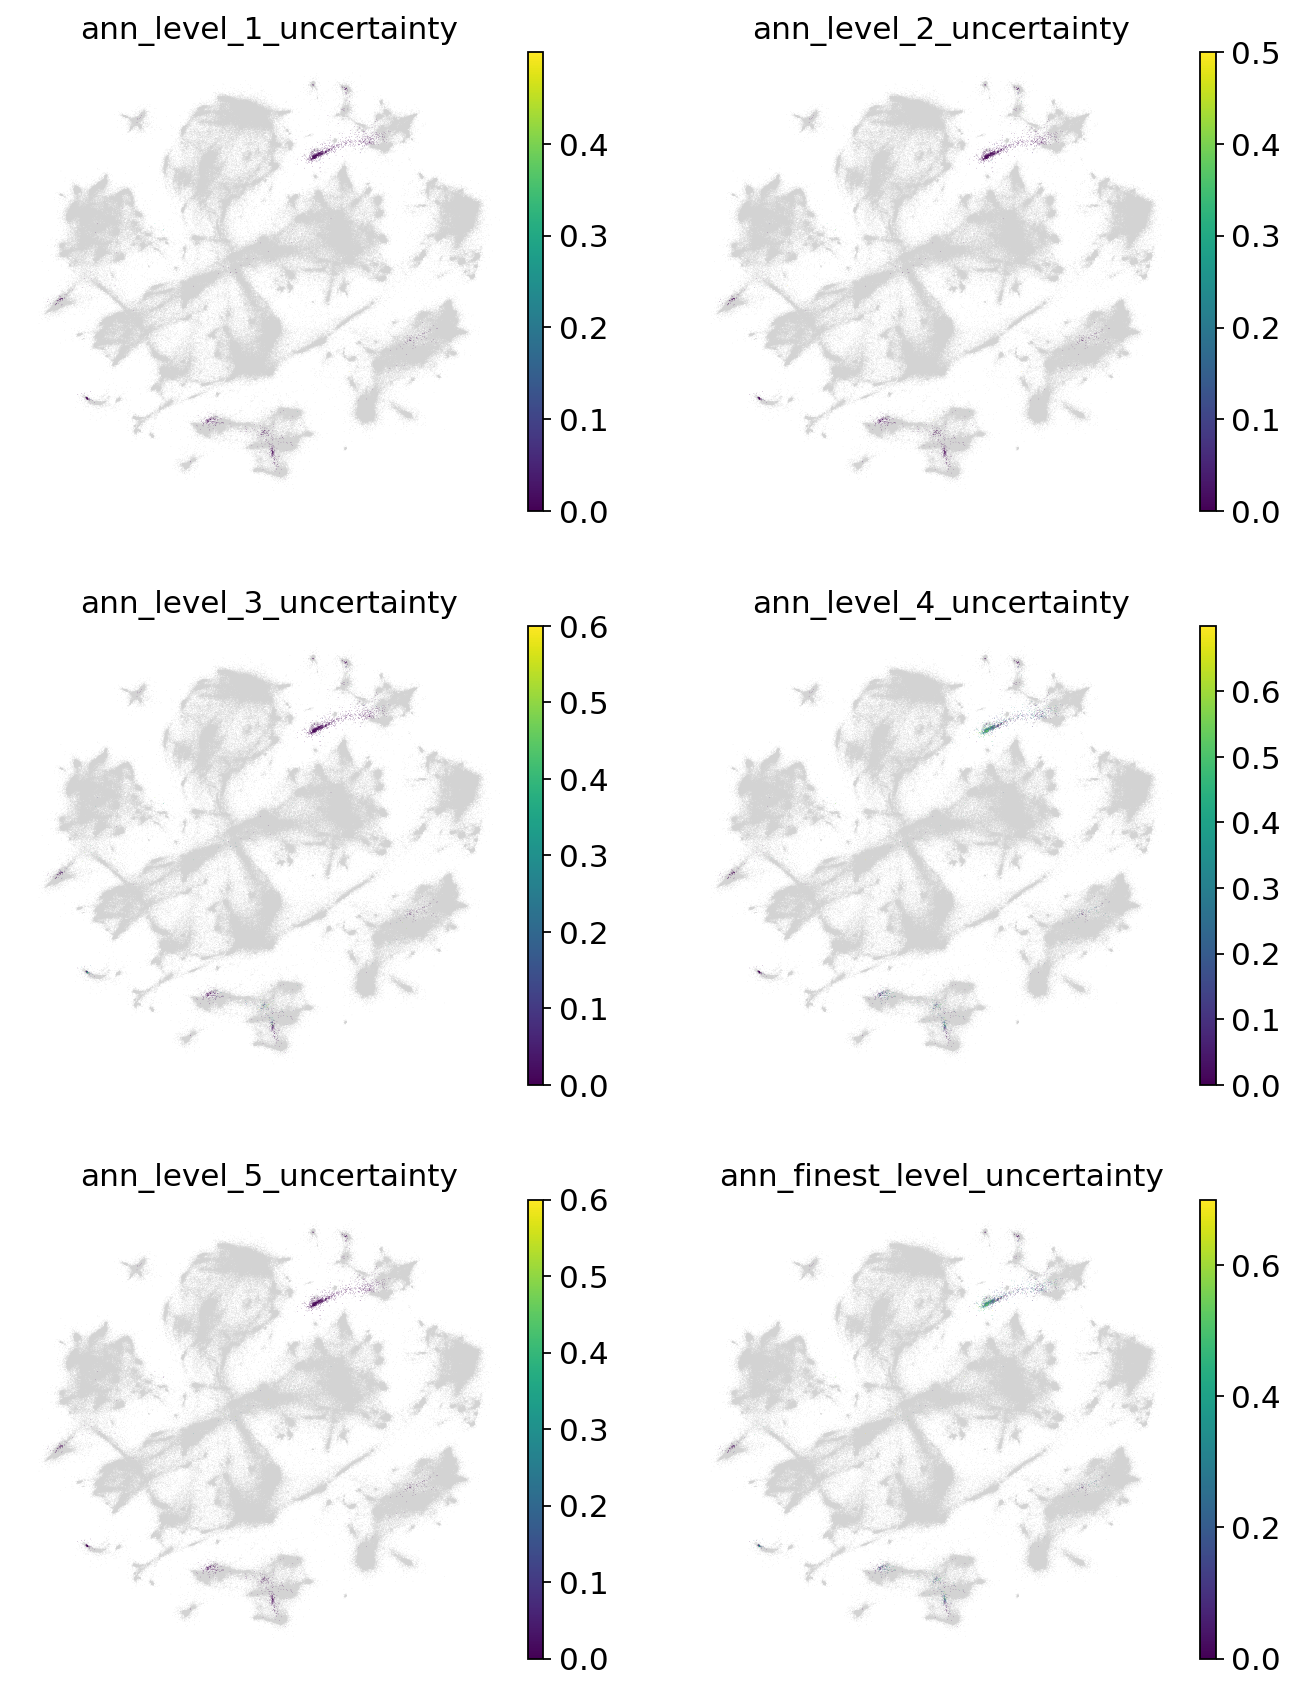

In [28]:
colors = [l + "_uncertainty" for l in label_keys]
sc.pl.embedding(
    combined_emb,
    basis=MDE_KEY,
    color=colors,
    ncols=2,
)

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:

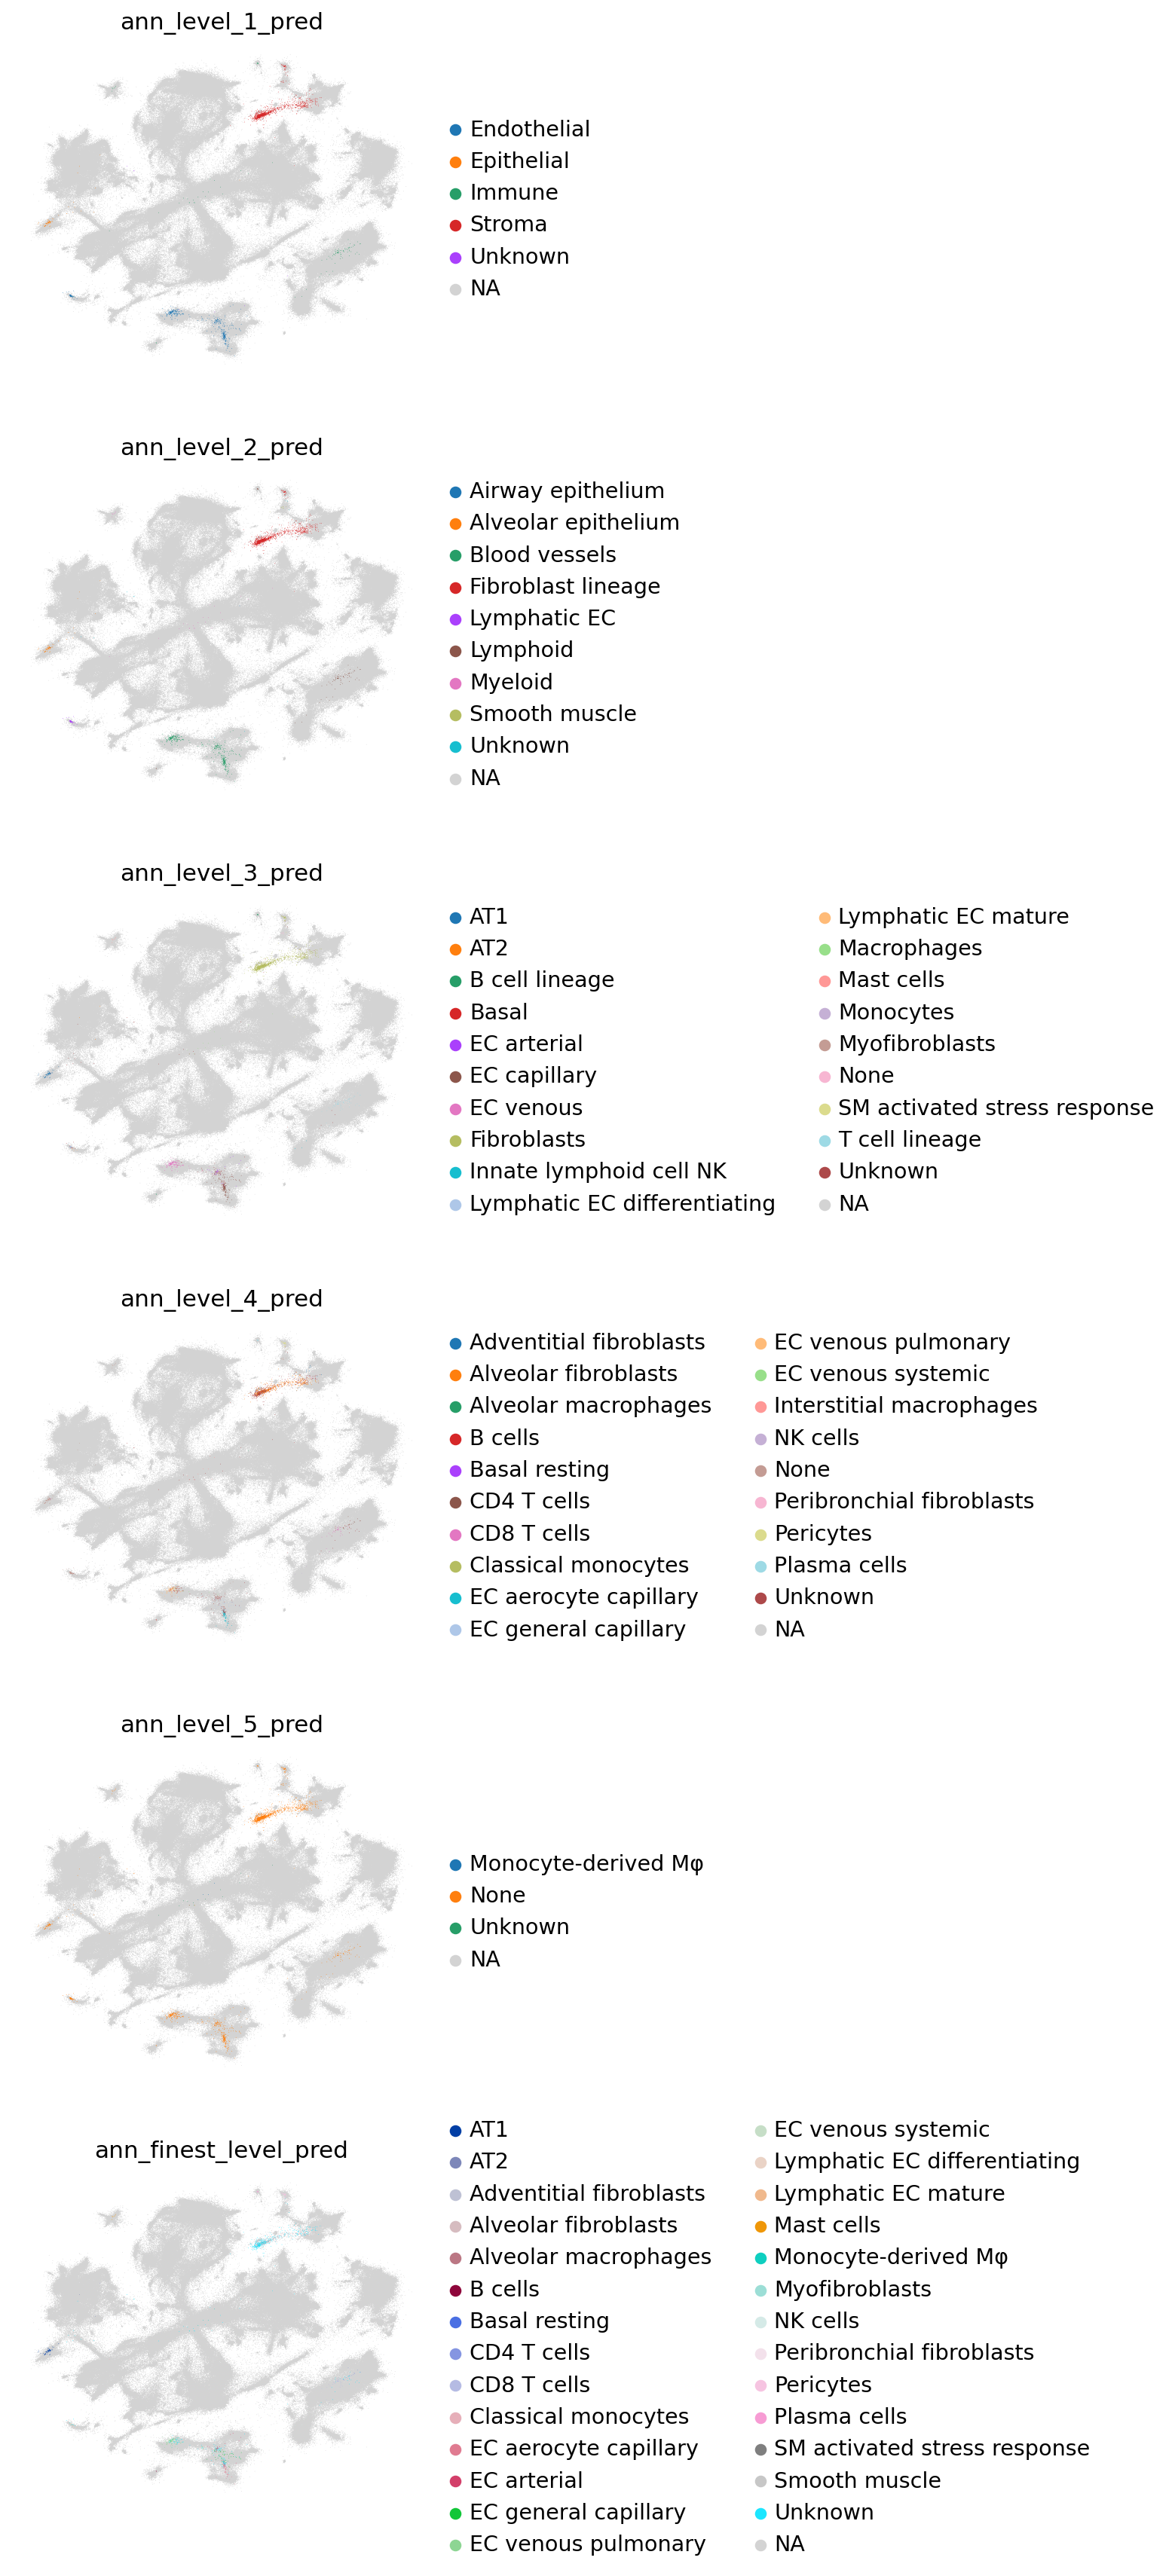

In [29]:
colors = [l + "_pred" for l in label_keys]

sc.pl.embedding(combined_emb, basis=MDE_KEY, color=colors, ncols=1, size=0.5)

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


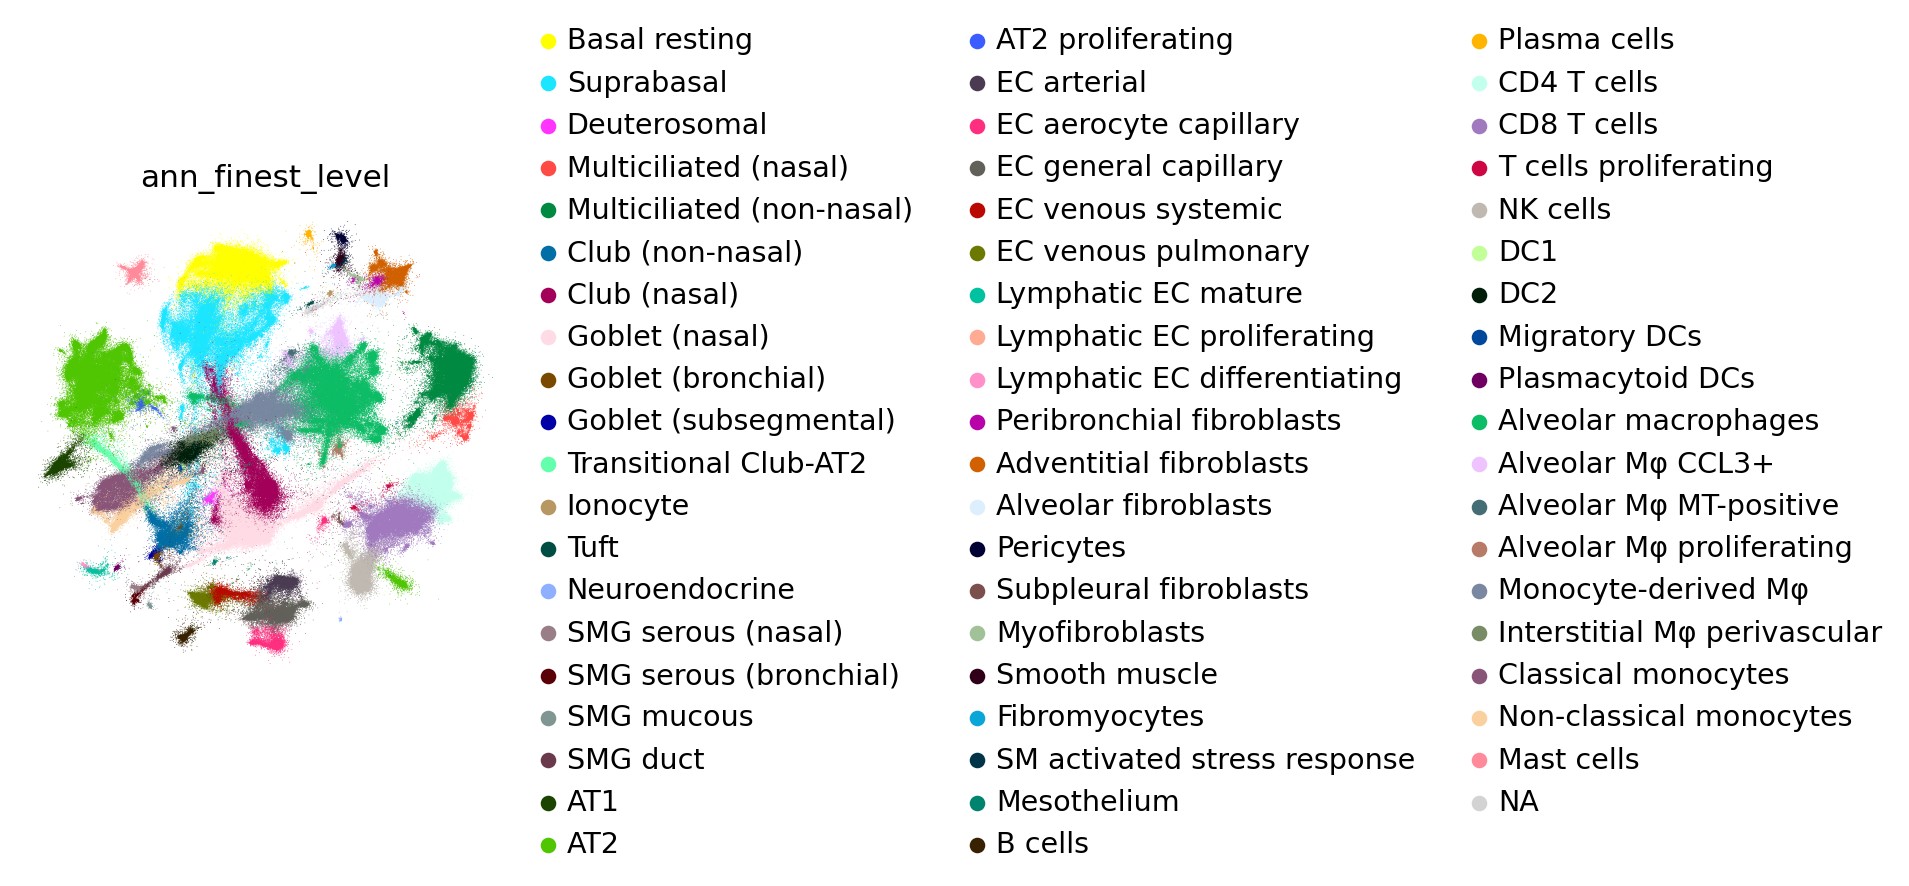

In [30]:
sc.pl.embedding(
    combined_emb, basis=MDE_KEY, color="ann_finest_level", ncols=1, size=0.5
)